![](IMG-1818.JPG)

In [1]:
import numpy as np
import MDAnalysis
import sympy as sp

**Micro to macroscopic heat transfer**

Fourier's law relates the macroscopic heat current to the temperature gradient:

$J=-\lambda\nabla T$

where we find $\lambda$ using the Green-Kubo formula:

$\lambda= \frac{1}{3VK_{B}T^2} \int_{0}^{\infty} \langle j(0) \cdot j(t) \rangle \, \mathrm{d}t$

For the integration component, we're going to preprocess our trajectory into the time-stamped microscopic heat currents, $j$, and use a numerical method to perform the integration.

In [2]:
def gk_heat_current(kb, volume, temperature, integrated_heat_current):
    gk_hc = 1 / (3 * volume * kb * temperature**2) * integrated_heat_current
    return gk_hc



I'm using the lowercase $j$ to signify the microscopic heat current:

$j(t) = \frac{d}{dt} \sum_{i=1}^N r_i e_i $

$r_i$ is the atomic position and $e_i$ is the microscopic site energy. The microscopic site energy is a combination of kinetic and potential energies:

$e_i = \frac{1}{2} [ m_i |v_i|^2 + \sum_{j}{\phi(r_{ij})}]$

In [3]:
def site_energy(mass, velocities, lj_potentials):
    se = 0.5 * (mass * abs(velocities)**2 + np.sum(lj_potentials, axis=0))
    return se

where $v_i$ is the velocity of particle $i$ and $\phi$ is the interatomic, Lennard Jones potential:

$\phi(r_{ij}) = 4 \epsilon [( \frac{\sigma}{r_{ij}} )^{12} - ( \frac{\sigma}{r_{ij}} )^6]$

In [4]:
def lj_potential(distance, epsilon, sigma):
    lj = 4 * epsilon * ((sigma/distance)**12 - (sigma/distance)**6)
    np.nan_to_num(lj, copy=False)
    return lj

where $r_{ij}$ are the interatomic distances. This simplifies to the final experession:

$j(t) = \sum_{i}{v_{i} e_{i}} + \frac{1}{2} \sum_{i}\sum_{j>i}[{(v_{j}+v_{i}) \cdot F_{ij}]r_{ij}}$ 

where $F_{ij}$ is the force exerted on atom $i$ from its LJ interaction with atom $j$: $F_{ij} = -\frac{\partial \phi}{\partial r_{ij}}$

In [5]:
def microscopic_heat_current(site_energies, velocities, distances, forces):
    micro_hc = np.sum(velocities * site_energies) + 0.5 * np.sum(np.sum(velocities * 
                                                             np.nan_to_num(forces)) * distances)
    return micro_hc

**Calculating in MDAnalysis**

There are $\sum_{i=1}^{N-1}{i}$ pairwise distances and $N$ velocities we need to calculate to compute the microscopic energy of every atom in our system

In [13]:
# before we start lets define some variables

kb = 0.0083144621 #KJ/mol K
sigma = .34 #nm
epsilon = 0.99774 #KJ/mol
mass = 39.948 #AU
timestep = 0.002 # in ps

# should the timestep be the md timestep
# or should the xtc write frequency be 
# taken into account?

In [19]:
u = MDAnalysis.Universe("argon.pdb", "traj.trr")
u.atoms[u.atoms.types == 'A'].masses = mass
pdbtrj = "argon.pdb"
heat_current = []

with MDAnalysis.Writer(pdbtrj, multiframe=True, bonds=None, n_atoms=u.atoms.n_atoms) as PDB:
    i = 0
    for ts in u.trajectory[:10]:
        pairwise_distances = np.zeros((u.atoms.n_atoms,u.atoms.n_atoms))
        pairwise_velocities = np.zeros((u.atoms.n_atoms,u.atoms.n_atoms))
        for atom_a in range(u.atoms.n_atoms):
            for atom_b in range(atom_a + 1 , u.atoms.n_atoms):
                
                # calculate distances
                distance = np.sqrt(np.sum((u.atoms[atom_a].position -
                                           u.atoms[atom_b].position)**2))/10 #A to nm
                pairwise_distances[atom_a,atom_b] = distance
                
                # calculate d(r_ij) / dt
                relative_velocity = np.sqrt(np.sum((u.atoms[atom_a].velocity -
                                           u.atoms[atom_b].velocity)**2))
                pairwise_velocities[atom_a,atom_b] = relative_velocity
                
        #compute velocities
        velocities = np.sqrt(np.sum(u.atoms.velocities**2, axis=1))
        
        #compute forces
        forces = np.sqrt(np.sum(u.atoms.forces**2, axis=1))
        
        # 1) compute LJ
        lj_potentials = lj_potential(pairwise_distances, epsilon, sigma)
       
        # 2) compute site energy
        site_energies = site_energy(mass, velocities, lj_potentials)
        
        if i > 0:
            pairwise_forces = -(lj_potentials - 
                                previous_lj_potentials) / (pairwise_distances - 
                                                           previous_pairwise_distances)
            # 3) compute micro heat current
            micro_hc = microscopic_heat_current(site_energies, pairwise_velocities,
                                                pairwise_distances, pairwise_forces)
            heat_current.append(micro_hc)
        
        previous_lj_potentials = lj_potentials
        previous_pairwise_distances = pairwise_distances
        
        PDB.write(u.atoms)
        i += 1
        if i < 10:
            print("Frame {}: "
                  "min/max velocities: {:.1f}...{:.1f} nm/ps".format(ts.frame, 
                                                                 velocities.min(), 
                                                                 velocities.max()))
            print("Frame {}: "
                  "min/max lj_potentials: {:.1f}...{:.1f} KJ/mol".format(ts.frame, 
                                                                 np.nanmin(lj_potentials), 
                                                                 np.nanmax(lj_potentials)))
        if 10 > i > 1:
            print("Frame {}: "
                  "micro heat current: {:.1f} KJ".format(ts.frame, micro_hc))

print("Wrote PDB trajectory for Argon with distances in bfactor field")

/home/wesleybeckner/.local/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:72: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


Frame 0: min/max velocities: 0.1...5.5 A
Frame 0: min/max lj_potentials: -0.9...0.0 KJ/mol


/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


Frame 1: min/max velocities: 0.1...5.0 A
Frame 1: min/max lj_potentials: -1.0...4.2 KJ/mol
Frame 1: micro heat current: 3716012473.9 KJ
Frame 2: min/max velocities: 0.2...6.0 A
Frame 2: min/max lj_potentials: -1.0...3.1 KJ/mol
Frame 2: micro heat current: 4591803381.9 KJ
Frame 3: min/max velocities: 0.2...6.0 A
Frame 3: min/max lj_potentials: -1.0...10.2 KJ/mol
Frame 3: micro heat current: 2902303375.6 KJ
Frame 4: min/max velocities: 0.3...7.9 A
Frame 4: min/max lj_potentials: -1.0...3.0 KJ/mol
Frame 4: micro heat current: 2165019219.1 KJ
Frame 5: min/max velocities: 0.3...5.5 A
Frame 5: min/max lj_potentials: -1.0...3.8 KJ/mol
Frame 5: micro heat current: 1714668810.8 KJ
Frame 6: min/max velocities: 0.2...5.7 A
Frame 6: min/max lj_potentials: -1.0...2.9 KJ/mol
Frame 6: micro heat current: 1067363987.0 KJ
Frame 7: min/max velocities: 0.3...5.9 A
Frame 7: min/max lj_potentials: -1.0...3.8 KJ/mol
Frame 7: micro heat current: 979540643.7 KJ
Frame 8: min/max velocities: 0.2...6.1 A
Frame 8

**Unit Conversions**

The following are from the GROMACS manual:

| Quanitity | Symbol | Units |
|---|---|---|
| velocity | *v* | $nm \space ps^{-1} \space or \space 1000 \space m s^{-1}$ |
| length | r | $10^{-9} m$ |
| mass | m | $ 1.660 538 921 x 10^{-27} kg $ |
| time | t | $ 10^{-12} s $ |
| temperature | K | $K$ |
| force | F | $KJ \space mol^{-1} \space nm^{-1}$ |

In [18]:
u.atoms[100].position

array([ 3.641   , 14.565001, 14.565001], dtype=float32)

In [20]:
print(pairwise_velocities[:3])
print(pairwise_forces[:3])
print(pairwise_distances[:3])

[[0.         3.62564802 5.1666379  ... 3.4837029  2.53749013 3.05304861]
 [0.         0.         4.17716503 ... 1.83053863 2.49247622 2.5765872 ]
 [0.         0.         0.         ... 3.2197969  2.74619532 4.67313719]]
[[            nan -3.28339070e-06 -6.21306281e-06 ... -1.47709258e-02
  -1.09398735e-01 -4.43879878e+00]
 [            nan             nan -2.32991165e-06 ... -2.17548511e-05
  -1.48424816e-05 -7.42463331e-06]
 [            nan             nan             nan ... -3.24581068e-05
  -2.39331840e-05 -1.31726383e-05]]
[[0.         3.7890213  3.47293701 ... 1.13412371 0.85463076 0.46293979]
 [0.         0.         4.00438271 ... 2.90923347 3.05787697 3.39182014]
 [0.         0.         0.         ... 2.74365005 2.86722374 3.14381886]]


In [103]:
# np.save("argon_heat_currents_2.npy", heat_current)

In [27]:
hc = np.load("argon_heat_currents_2.npy")
# hc = heat_current

In [28]:
import matplotlib.pyplot as plt

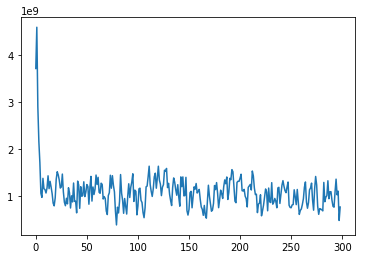

In [29]:
plt.plot(hc)

We have the heat currents, now we need to compute the integral

$\lambda= \frac{1}{3VK_{B}T^2} \int_{0}^{\infty} \langle j(0) \cdot j(t) \rangle \, \mathrm{d}t$

In [30]:
# create timestep array (ps)
# timestep is dt * nstxout
# 0.002 * 100
dt_array = np.arange(0,1000,.2)

In [31]:
from scipy.integrate import simps

In [32]:
integrated_hc = simps(np.dot(hc[0], hc))#, dt_array)

In [33]:
box_length = 29.130 # A
volume = box_length**3 # A^3
temperature = 100 # K

In [34]:
# compute the thermal conductivity
# need to convert to W/M K
gk_heat_current(kb, volume, temperature, integrated_hc)

195334669246026.1

# Things to look at

https://aip.scitation.org/doi/10.1063/1.4749265

https://courses.physics.illinois.edu/phys466/sp2011/projects/2004/Team1/index.html

https://pubs.acs.org/doi/10.1021/acs.analchem.7b05350
